In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import re 
from operator import itemgetter
import warnings
from scipy.integrate import solve_ivp
from scipy import optimize
import seaborn as sns
import PyCCELL_PRFQT as px
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')

![../images/master_eq_model.png](../images/master_eq_model.png)

In [62]:
sns.set_palette('colorblind')

# Load the data

In [63]:
# load
correct = px.mainf('../results/SHERLOCK/target_concentration/sherlock_target_concentr.xlsx'
               ,70,"YES",'col',['K16','L16','M16'])

# Rename the columns

correct.rename(columns={"['H9', 'I9', 'J9']": '10µM_FITC',
                   "['H10', 'I10', 'J10']": '5µM_FITC',
                     "['H11', 'I11', 'J11']":'2µM_FITC' ,
                     "['H12', 'I12', 'J12']": '1µM_FITC',
                    "['H13', 'I13', 'J13']": '0.1µM_FITC',
                      "['H14', 'I14', 'J14']":'0.01µM_FITC' ,
                     "['H15', 'I15', 'J15']": '0.001µM_FITC',
                    "['H16', 'I16', 'J16']": 'NC_FITC',
                     "['K9', 'L9', 'M9']": '1µM_target',
                   "['K10', 'L10', 'M10']": '0.1µM_target',
                     "['K11', 'L11', 'M11']":'0.01µM_target' ,
                     "['K12', 'L12', 'M12']": '1nM_target',
                    "['K13', 'L13', 'M13']": '0.1nM_target',
                      "['K14', 'L14', 'M14']":'0.01nM_target' ,
                     "['K15', 'L15', 'M15']": '0.1pM_target',
                    "['K16', 'L16', 'M16']": 'NC_target',
                     0: '10µM_FITC_std',
                   1: '1µM_target_std',
                     2: '5µM_FITC_std',
                     3: '0.1µM_target_std',
                    4: '2µM_FITC_std',
                    5: '0.01µM_target_std',
                   6: '1µM_FITC_std',
                     7:'1nM_target_std' ,
                     8: '0.1µM_FITC_std',
                    9: '0.1nM_target_std',
                    10: '0.01µM_FITC_std',
                   11: '0.01nM_target_std',
                     12: '1nM_FITC_std',
                     13: '0.1pM_target_std',
                    14: 'NC_FITC_std',
                    15:'NC_target_std'},
          inplace=True, errors='raise')

correct.head()

,10µM_FITC,1µM_target,5µM_FITC,0.1µM_target,2µM_FITC,0.01µM_target,1µM_FITC,1nM_target,0.1µM_FITC,0.1nM_target,...,1µM_FITC_std,1nM_target_std,0.1µM_FITC_std,0.1nM_target_std,0.01µM_FITC_std,0.01nM_target_std,1nM_FITC_std,0.1pM_target_std,NC_FITC_std,NC_target_std
0,9.697937,0.055873,4.803333,0.000000,1.954603,0.009841,1.135397,0.0,0.391905,0.0,...,0.136073,0.244756,0.082644,0.091951,0.058089,0.056878,0.054902,0.007866,0.014142,0.011208
1,8.678571,0.388095,4.078571,0.000000,1.334603,0.000000,0.628889,0.0,0.000000,0.0,...,0.133369,0.726438,0.038502,0.847473,0.063122,0.623463,0.079329,0.866017,0.084873,0.758101
2,12.689206,1.199524,6.717937,0.078254,2.983651,0.000000,1.790794,0.0,1.228095,0.0,...,0.394305,0.336887,0.207361,0.194752,0.291521,0.172988,0.148309,0.156005,0.152101,0.185042
3,12.426984,2.635714,6.500952,0.618413,2.926667,0.000000,2.038095,0.0,1.305397,0.0,...,0.161015,0.335035,0.191609,0.177314,0.119023,0.159265,0.179541,0.169277,0.108229,0.262830
4,12.210159,3.302222,6.296508,1.371587,2.918889,0.000000,2.135079,0.0,1.412381,0.0,...,0.173781,0.338014,0.228196,0.181659,0.113460,0.053356,0.216622,0.189353,0.135465,0.251958


## New data

In [64]:
targ = pd.read_csv('../results/SHERLOCK/all_targets/pos_targets.csv')
targ.head()

,Unnamed: 0,PositiveC,100nM_Trigopus,SD,Synthetic DNA,10nM_Trigopus,IL17,40s,100µM_ToxR,EF1a,...,DnaJ09,DnaJ10_f,flaA,ToxR_f,100nM_ToxR,ToxRm1,10nM_ToxR,ToxRm2,100nM_DnaJ07,10nM_DnaJ07
0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.090476,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,3,0.0,0.0,1.211587,0.000000,0.0,0.0,0.0,0.000000,0.526190,...,0.000000,0.0,0.0,0.660476,0.000000,0.506190,0.0,0.0,0.0,0.0
4,4,0.0,0.0,1.891746,0.507302,0.0,0.0,0.0,0.376825,1.000635,...,0.193651,0.0,0.0,1.126190,0.407937,1.189048,0.0,0.0,0.0,0.0


# Define the model

In [65]:
def system(t,z,param):
    
    GC,GCT,Pa,Pi,Tc,Tu= z
    
    k1,k3,k4 = param  
    
    dGCdt = -(k1*GC*Tu) + k4 * GCT
    
    dGCTdt = - dGCdt
    
    dPadt = k3*GCT*Pi

    dPidt = -dPadt
    
    dTcdt = k4*GCT
    
    dTudt = -(k1*GC*Tu)
    
    return [dGCdt, dGCTdt, dPadt, dPidt, dTcdt, dTudt]

def error(param,obs):
    
    times = np.linspace(0,480,97) # number of time points
    
    t = np.linspace(0,500,500) # number of time point to solve 
    
    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([param]),
                    t_eval=times,method='DOP853',dense_output=True,rtol=1e-8,atol=1e-8)
    
    m = sol.sol(times)
    
    err = []
        
    for i in range(len(m.tolist()[2])): #don't forget that the [2] is because we are fitting the dPadt 
        err.append((obs[i]-m.tolist()[2][i])**2)  
        
    
    erro = np.sum(err)

    return erro

## Fit the data by adjusting the parameters by hand

In [66]:
#Initial conditions (concentrations in microM)
GC0 = 0.4 
GCT0 = 0.
Pa0 = 0.
Pi0 = 4.5
Tc0 = 0.
Tu0 = 1

# Parameters (in /min)
k1 = 1
k3 = 0.15
k4 = 0.01


z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
param  = [k1,k3,k4]

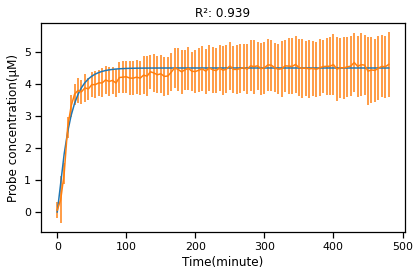

In [67]:
times = np.linspace(0,480,97)

sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([param]),
                    t_eval=times,dense_output=True)
m = sol.sol(times)
r = r2_score(correct[correct.columns[1]],m[2])


sns.set_context('notebook')
sns.set_palette("tab10")

plt.plot(times,m[2])
plt.errorbar(times,correct[correct.columns[1]],yerr=correct['1nM_target_std'])
plt.xlabel('Time(minute)')
plt.ylabel('Probe concentration(µM)')
plt.title('R²: '+str(round(r,3)))
plt.tight_layout()
#plt.xlim(50,480)
#plt.savefig("images/SHERLOCK/modeling/first_attempt.png",dpi=300)
plt.show()

## With minimization

In [68]:
#Initial conditions (concentrations in microM)
GC0 = 0.4 
GCT0 = 0.
Pa0 = 0.
Pi0 = 4.5
Tc0 = 0.
Tu0 = 1

# Parameters (in /min)
k1 = 1
k3 = 0.15
k4 = 0.01


z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
param  = [k1,k3,k4]

bnds = [(0.0001,1),(10,1000),(0.003,3)]
res = optimize.minimize(error, param, args=(list(targ.PositiveC)),method='Nelder-Mead')#,bounds=bnds)#

In [69]:
res.x

array([0.05053055, 0.03458599, 0.02543591])

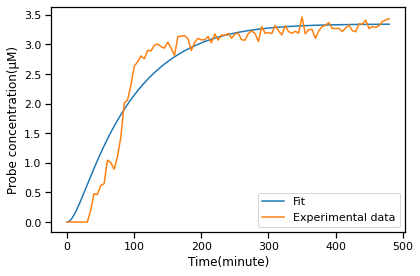

In [70]:
#times = np.linspace(0,480,97)
times = np.linspace(0,480,97*3-1)
times_exp = np.linspace(0,480,97)

sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                	t_eval=times,dense_output=True)
m = sol.sol(times)

## 
counter = 0
cleaned_m = []
for val in m[2]:
    if counter%3 == 0:
        cleaned_m.append(val)
    counter +=1
    
#r = r2_score(correct[correct.columns[1]],m[2])
r = r2_score(targ.PositiveC,cleaned_m)


sns.set_context('notebook')
#sns.set_palette("tab10")

plt.plot(times,m[2],label="Fit")
plt.errorbar(times_exp,targ.PositiveC,label="Experimental data")#,yerr=correct['0.1nM_target_std'])
plt.xlabel('Time(minute)')
plt.ylabel('Probe concentration(µM)')
#plt.title(f'R²: {(round(r*100))}, parameters: 1/k1={round(1/res.x[0],2)} min 1/k3={round(1/res.x[1],2)} min 1/k4={round(1/res.x[2],3)}min')
plt.tight_layout()
plt.legend()
#plt.xlim(0,50)
#plt.savefig("../images/SHERLOCK/modeling/better_model.png",dpi=300)
#plt.savefig("../images/fixed_model.png",dpi=300)
plt.show()

# Plot all the species in the model

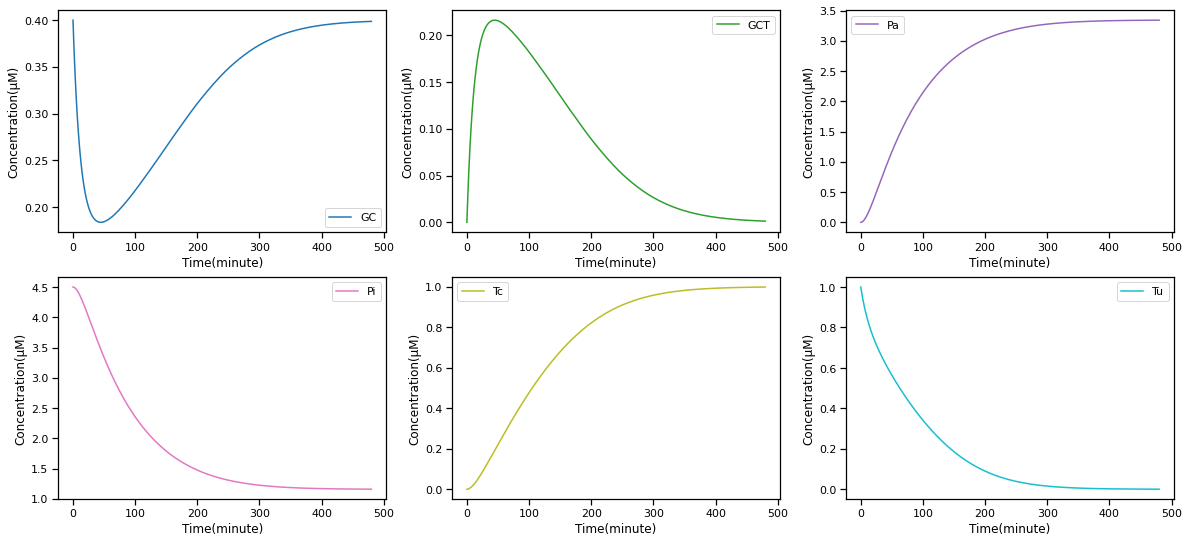

In [71]:
fig,ax = plt.subplots(2,3)
fig.set_size_inches(20,9)

def get_cmap(n, name='tab10'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(6)

counter=0
name = ["GC",'GCT',"Pa","Pi","Tc","Tu"]
for r in range(2):
    for c in range(3):
        ax[r,c].plot(times,m[counter],label=name[counter],c=cmap(counter))
        ax[r,c].set_xlabel('Time(minute)')
        ax[r,c].set_ylabel('Concentration(µM)')
        ax[r,c].legend()
        ax[r,c].ticklabel_format(useOffset=False)
        #ax[r,c].set_xlim(0,75)
        counter += 1
    
#plt.savefig("../images/SHERLOCK/modeling/all_species.png",dpi=300)
#plt.savefig("all_species.png",dpi=300)
plt.show()

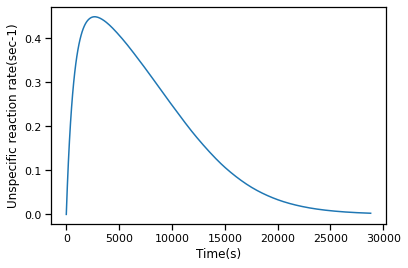

In [72]:
k = []

for i in range(len(m[1])):
    k.append(res.x[1]*m[1][i])
k_s = [x*60 for x in k ] 
times_s = [x*60 for x in times]

plt.plot(times_s,k_s)
plt.ylabel("Unspecific reaction rate(sec-1)")
plt.xlabel('Time(s)')
#plt.savefig('../images/SHERLOCK/modeling/reaction_rate_poc.png',dpi=300)
plt.show()

# Test different target concentration

In [73]:
correct.columns

Index(['10µM_FITC', '1µM_target', '5µM_FITC', '0.1µM_target', '2µM_FITC',
       '0.01µM_target', '1µM_FITC', '1nM_target', '0.1µM_FITC', '0.1nM_target',
       '0.01µM_FITC', '0.01nM_target', '0.001µM_FITC', '0.1pM_target',
       'NC_FITC', 'NC_target', 'Time', '10µM_FITC_std', '1µM_target_std',
       '5µM_FITC_std', '0.1µM_target_std', '2µM_FITC_std', '0.01µM_target_std',
       '1µM_FITC_std', '1nM_target_std', '0.1µM_FITC_std', '0.1nM_target_std',
       '0.01µM_FITC_std', '0.01nM_target_std', '1nM_FITC_std',
       '0.1pM_target_std', 'NC_FITC_std', 'NC_target_std'],
      dtype='object')

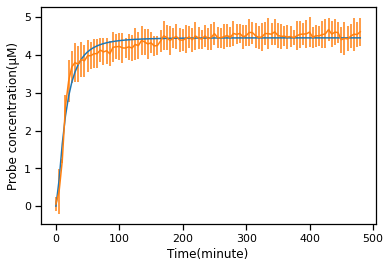

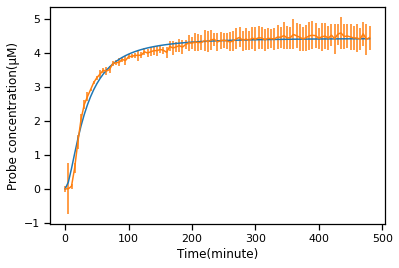

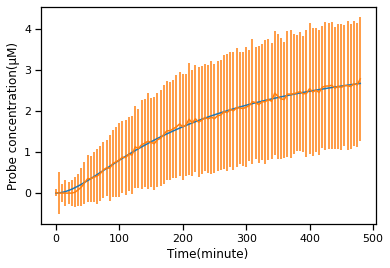

In [74]:
constants = pd.DataFrame()

for i,j,k in zip([1,3,5],['1µM_target_std','0.1µM_target_std','0.01µM_target_std'],[1,0.1,0.01]):
    z = [GC0,GCT0,Pa0,Pi0,Tc0,k]
    res = optimize.minimize(error, param, args=(list(correct[correct.columns[i]])),method='Nelder-Mead')
    times = np.linspace(0,480,97)

    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)
    k1,k2,k3 = res.x[0],res.x[1],res.x[2]
    
    constants[j.strip('std')] = [k1,k2,k3]
    
    r = r2_score(correct[correct.columns[i]],m[2])

    plt.plot(times,m[2],label="Fit")
    plt.errorbar(times_exp,correct[correct.columns[i]],label="Experimental data",yerr=correct[j])
    plt.xlabel('Time(minute)')
    plt.ylabel('Probe concentration(µM)')
    #plt.title(f'R²: {(round(r*100))}, parameters: 1/k1={round(1/res.x[0],2)} min 1/k3={round(1/res.x[1],2)} min 1/k4={round(1/res.x[2],3)}min')
    #plt.legend()
    plt.show()

constants = constants.rename({0: 'k1', 1: 'k3',2:'k4'}, axis='index')



In [75]:
constants

,1µM_target_,0.1µM_target_,0.01µM_target_
k1,0.044815,0.359719,0.062993
k3,1.217653,0.327650,0.341542
k4,0.269283,0.008129,0.002564


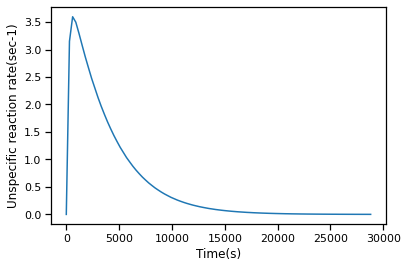

In [96]:
times = np.linspace(0,480,97)

d = 1

z = [GC0,GCT0,Pa0,Pi0,Tc0,d]

sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([constants[str(d)+'µM_target_']]),
                    t_eval=times,dense_output=True)
m = sol.sol(times)

    
k = [] # list that will contain all the value of k3

'''
K3 depends on the concentration of Pi to compute it's value
I multiply each value of Pi by the value obtained for k3
by the minimization
m[3] is the solution of the system of ODE for Pi
constants is the dataframe where I stored all the values of k
k_s is a list of value of k but in seconds-1 (min-1 * 60)
I then plot the value of k3 as a function of the concentration of inactive probe
'''

for i in range(len(m[3])): 
    k.append(constants.iloc[1].values[0]*m[1][i])
    
k_s = [x*60 for x in k ] 
times_s = [x*60 for x in times]

plt.plot(times_s,k_s)
plt.ylabel("Unspecific reaction rate(sec-1)")
plt.xlabel('Time(s)')

#plt.savefig('../images/SHERLOCK/modeling/reaction_rate_poc.png',dpi=300)
plt.show()

In [77]:
constants

,1µM_target_,0.1µM_target_,0.01µM_target_
k1,0.044815,0.359719,0.062993
k3,1.217653,0.327650,0.341542
k4,0.269283,0.008129,0.002564


In [90]:
def constant(t,k,p,z):
    if k == 1:
        f,l,label = 5,0,'Cas-target binding rate (sec-1)'
    else:
        f,l,label = 1,1,"Unspecific reaction rate (sec-1)"
    
    times = np.linspace(0,480,97)
    times_s = [x*60 for x in times]
 
    sol = solve_ivp(system,t_span =[0, times.max()], y0= [GC0,GCT0,Pa0,Pi0,Tc0,z] , args =([constants[t]]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)

    k = [] # list that will contain all the value of k3

    for i in range(len(m[f])): 
        k.append(constants.iloc[l].values[p]*m[f][i])

    k_s = [x*60 for x in k ]

    plt.plot(times_s,k_s)
    plt.xlabel("Time (sec)")
    plt.ylabel(label)
    #plt.show()

#const('1nM_target_',1)

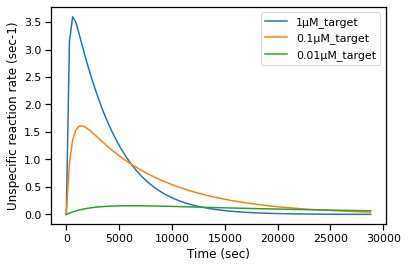

In [97]:
for t,p,z in zip(constants.columns,range(3),[1,0.1,0.01]):
    constant(t,3,p,z)

legend = [x.strip('_') for x in constants.columns]
plt.legend(legend)

#plt.yscale('log')
#plt.xscale('log')
plt.savefig('../images/SHERLOCK/modeling/catalytic_rates.png',dpi=300)
plt.show()

# Fit individual experimental curves

In [ ]:
df = px.excelreader('../results/SHERLOCK/target_concentration/sherlock_target_concentr.xlsx'
               ,70,"YES")
for i,j in zip(['K9','L9','M9'],['K16','L16','M16']):
    df[i] = df[i] - df[j]

df[['K9','L9','M9','Time']].plot(x='Time')
plt.plot(times,m[2],label="Fit")
plt.ylabel("[Pa] (µM)")
plt.legend()
plt.show()

In [ ]:
const = pd.DataFrame()

for i,j in zip(['K9','L9','M9'],[5.5,Pi0,Pi0]):
    z = [GC0,GCT0,Pa0,j,Tc0,Tu0]
    res = optimize.minimize(error, param, args=(list(df[i])),method='Nelder-Mead')
    times = np.linspace(0,480,97)

    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)
    k1,k2,k3 = res.x[0],res.x[1],res.x[2]
    
    const[i] = [k1,k2,k3]
    
    r = r2_score(df[i],m[2])

    plt.plot(times,m[2],label="Fit "+ str(i))
    plt.plot(times,df[i],label="Experimental data "+str(i))
    plt.xlabel('Time(minute)')
    plt.ylabel('Probe concentration(µM)')
    plt.legend()
    #plt.show()

const = const.rename({0: 'k1', 1: 'k3',2:'k4'}, axis='index')

plt.savefig('../images/SHERLOCK/modeling/fitting_individual_curves.png',dpi=300)

In [131]:
const

,K9,L9,M9
k1,0.116694,7.950303,0.049948
k3,0.523984,0.088840,1.191031
k4,0.188385,0.045989,0.353594


In [153]:
def constante(t,k,p):
    if k == 1:
        f,l,label = 5,0,'Cas-target binding rate (sec-1)'
    else:
        f,l,label = 1,1,"Unspecific reaction rate (sec-1)"
    
    times = np.linspace(0,480,97)
    times_s = [x*60 for x in times]
 
    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([const[t]]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)

    k = [] # list that will contain all the value of k3

    for i in range(len(m[f])): 
        k.append(const.iloc[l].values[p]*m[f][i])

    k_s = [x*60 for x in k ]

    plt.plot(times_s,k_s)
    plt.xlabel("Time (sec)")
    plt.ylabel(label)
    return k_s

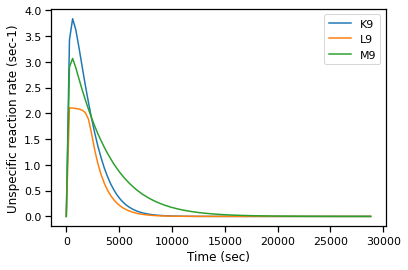

In [155]:
z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
ks = []
for i,j in zip(const.columns,range(3)):
    ks.append(constante(i,3,j))
    
legend = [x for x in const.columns]
legend.append("Fit on the mean")

#constant(constants.columns[0],3,0,1)

plt.legend(legend)

#plt.savefig('../images/SHERLOCK/modeling/catalytic_rates_individual_curves.png',dpi=300)
plt.show()

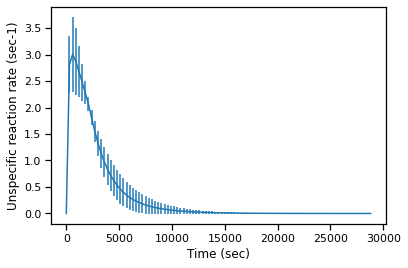

In [156]:
k_m = [np.mean([ks[0][i],ks[1][i],ks[2][i]]) for i in range(len(ks[0]))]
k_sd = [np.std([ks[0][i],ks[1][i],ks[2][i]]) for i in range(len(ks[0]))]

plt.errorbar(times_s,k_m,yerr=k_sd)
plt.xlabel("Time (sec)")
plt.ylabel("Unspecific reaction rate (sec-1)")

plt.savefig('../images/SHERLOCK/modeling/catalytic_rates_individual_mean.png',dpi=300)
plt.show()

## Fitting K1

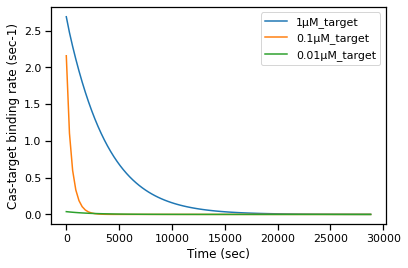

In [130]:
for t,p,z in zip(constants.columns,range(3),[1,0.1,0.01]):
    constant(t,1,p,z)

legend = [x.strip('_') for x in constants.columns]
plt.legend(legend)

#plt.yscale('log')
#plt.xscale('log')
#plt.savefig('../images/SHERLOCK/modeling/binding_rates.png',dpi=300)
plt.show()